In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import pyro.distributions as dist
from pyro.infer import MCMC, HMC, NUTS, Predictive
import pyro

from src.data.preprocessing import detrend, ffnn_input_vector
from src.models.paths import PROJECT_ROOT
from src.models.solid_earth_utils import greens_function, FFNN
from src.data.data_loader import load_uplift
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution

print(PROJECT_ROOT)
pyro.set_rng_seed(42)
%load_ext autoreload
%autoreload 2

/data/eigil/work/premis


In [165]:
def compute_error(trues, predicted):
    '''
    From course material
    '''
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    return corr, mae, rae, rmse

In [36]:
Nr = np.arange(1, 7).tolist()
radius = [6371e3, 6341e3, 6311e3, 5951e3, 5701e3, 3480e3]
density = [3.037e3, 3.230e3, 3.438e3, 3.871e3, 4.978e3, 10.750e3]
rigidity = [0.50605e11, 0.50605e11, 0.70363e11, 1.05490e11, 2.28340e11, 0.0000e11]
bulk = [5.7437e10, 5.7437e10, 9.9633e10, 1.5352e11, 3.2210e11, 1.1018e12]
viscosity = [1.0e55, 1.0e21, 1.0e21, 1.0e21, 2.0e21, 0.0e21]

df_em = pd.DataFrame(
    np.array([Nr, radius, density, rigidity, bulk, viscosity]).T,
    columns=["Nr", "radius", "density", "rigidity", "bulk", "viscosity"],
)

lmax = 256
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}

df = load_uplift()
height = df.Thickness.values
uplift = df.Up_kuaq.values

df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3230.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


In [ ]:
#  Gaussian Process models are :class:`~pyro.contrib.gp.util.Parameterized`
#     subclasses. So its parameters can be learned, set priors, or fixed by using
#     corresponding methods from :class:`~pyro.contrib.gp.util.Parameterized`. A typical
#     way to define a Gaussian Process model is

#         >>> X = torch.tensor([[1., 5, 3], [4, 3, 7]])
#         >>> y = torch.tensor([2., 1])
#         >>> kernel = gp.kernels.RBF(input_dim=3)
#         >>> kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
#         >>> kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
#         >>> gpr = gp.models.GPRegression(X, y, kernel)

#     There are two ways to train a Gaussian Process model:

#     + Using an MCMC algorithm (in module :mod:`pyro.infer.mcmc`) on :meth:`model` to
#       get posterior samples for the Gaussian Process's parameters. For example:

#         >>> hmc_kernel = HMC(gpr.model)
#         >>> mcmc = MCMC(hmc_kernel, num_samples=10)
#         >>> mcmc.run()
#         >>> ls_name = "GPR/RBF/lengthscale"
#         >>> posterior_ls = mcmc.get_samples()[ls_name]

# X = torch.tensor([[1., 5, 3], [4, 3, 7]])
#         >>> y = torch.tensor([2., 1])
#         >>> kernel = gp.kernels.RBF(input_dim=3)
#         >>> kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
#         >>> kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
#         >>> gpr = gp.models.GPRegression(X, y, kernel)

In [3]:
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
import pyro.contrib.gp as gp



In [101]:
def plot(plot_observed_data=False, plot_predictions=False, n_prior_samples=0,
         model=None, kernel=None, n_test=500):

    plt.figure(figsize=(12, 6))
    if plot_observed_data:
        plt.plot(X_train_tensor.view(-1,).numpy(), y_train_tensor.view(-1,).numpy(), 'kx')
    if plot_predictions:
        Xtest = torch.linspace(-4, 4, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest.double(), full_cov=True)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        plt.plot(Xtest.numpy(), mean.numpy(), 'r', lw=2)  # plot the mean
        plt.fill_between(Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
                         (mean - 2.0 * sd).numpy(),
                         (mean + 2.0 * sd).numpy(),
                         color='C0', alpha=0.3)
        plt.legend(["Data", "GP Posterior Mean"])
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (model.noise if type(model) != gp.models.VariationalSparseGP
                 else model.likelihood.variance)
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(torch.zeros(n_test), covariance_matrix=cov)\
                      .sample(sample_shape=(n_prior_samples,))
        plt.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    plt.xlim(-4, 4)

Sample: 100%|██████████| 200/200 [00:06, 32.44it/s, step size=1.01e+00, acc. prob=0.894]


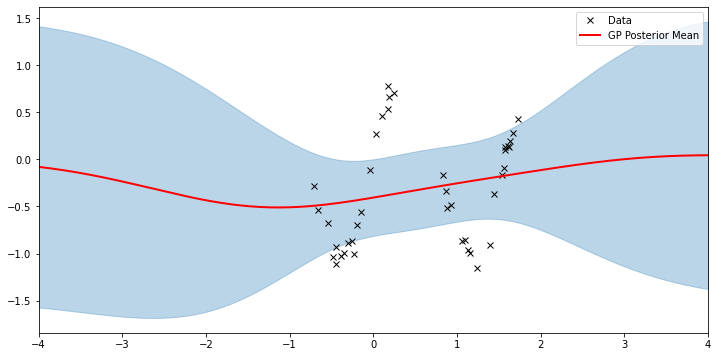

In [114]:
# Build torch.tensors
# generate some training data
X_train = np.hstack([-0.75 + np.random.rand(1,20), 0.75 + np.random.rand(1,20)]).T
y_train = np.sin(4.0*X_train) + 0.1*np.random.randn(len(X_train), 1)
N_train = len(y_train)

X_train_tensor = torch.from_numpy(X_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)
kernel = gp.kernels.RBF(input_dim=5)
kernel.set_prior("variance", dist.Uniform(torch.tensor(1.5), torch.tensor(2.5)))
kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(10.0), torch.tensor(20.0)))
gpr = gp.models.GPRegression(X_train_tensor, y_train_tensor, kernel)

hmc_kernel = NUTS(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=100)
mcmc.run()

# Xnew = torch.tensor([[2., 3, 1], [4, 3, 7]]) 
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

tensor([0.4218, 0.3329, 0.8084, 0.7291, 0.8738, 0.7646, 0.9420, 0.8570, 0.4890,
        0.6382], dtype=torch.float64)

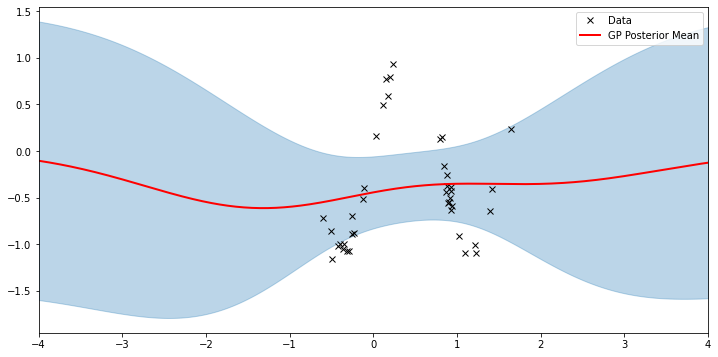

In [18]:
Xnew = torch.tensor([[2., 3, 1]])
f_loc, f_cov = gpr(Xnew, full_cov=True)


<bound method GPRegression.model of GPRegression(
  (kernel): RBF()
)>

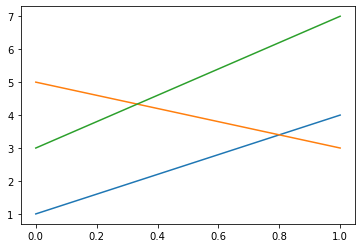

In [41]:
plt.plot(X)

In [2]:
import torch
from torch.distributions import constraints
from torch.nn import Parameter

import pyro 
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
from pyro.nn.module import PyroParam, pyro_method

In [78]:



class VariationalGP(GPModel):
    r"""
    Variational Gaussian Process model.
    This model deals with both Gaussian and non-Gaussian likelihoods. Given inputs\
    :math:`X` and their noisy observations :math:`y`, the model takes the form
    .. math::
        f &\sim \mathcal{GP}(0, k(X, X)),\\
        y & \sim p(y) = p(y \mid f) p(f),
    where :math:`p(y \mid f)` is the likelihood.
    We will use a variational approach in this model by approximating :math:`q(f)` to
    the posterior :math:`p(f\mid y)`. Precisely, :math:`q(f)` will be a multivariate
    normal distribution with two parameters ``f_loc`` and ``f_scale_tril``, which will
    be learned during a variational inference process.
    .. note:: This model can be seen as a special version of
        :class:`.SparseVariationalGP` model with :math:`X_u = X`.
    .. note:: This model has :math:`\mathcal{O}(N^3)` complexity for training,
        :math:`\mathcal{O}(N^3)` complexity for testing. Here, :math:`N` is the number
        of train inputs. Size of variational parameters is :math:`\mathcal{O}(N^2)`.
    :param torch.Tensor X: A input data for training. Its first dimension is the number
        of data points.
    :param torch.Tensor y: An output data for training. Its last dimension is the
        number of data points.
    :param ~pyro.contrib.gp.kernels.kernel.Kernel kernel: A Pyro kernel object, which
        is the covariance function :math:`k`.
    :param ~pyro.contrib.gp.likelihoods.likelihood Likelihood likelihood: A likelihood
        object.
    :param callable mean_function: An optional mean function :math:`m` of this Gaussian
        process. By default, we use zero mean.
    :param torch.Size latent_shape: Shape for latent processes (`batch_shape` of
        :math:`q(f)`). By default, it equals to output batch shape ``y.shape[:-1]``.
        For the multi-class classification problems, ``latent_shape[-1]`` should
        corresponse to the number of classes.
    :param bool whiten: A flag to tell if variational parameters ``f_loc`` and
        ``f_scale_tril`` are transformed by the inverse of ``Lff``, where ``Lff`` is
        the lower triangular decomposition of :math:`kernel(X, X)`. Enable this flag
        will help optimization.
    :param float jitter: A small positive term which is added into the diagonal part of
        a covariance matrix to help stablize its Cholesky decomposition.
    """
    def __init__(self, X, y, kernel, likelihood, mean_function=None,
                 latent_shape=None, whiten=False, jitter=1e-6):
        super().__init__(X, y, kernel, mean_function, jitter)

        self.likelihood = likelihood

        y_batch_shape = self.y.shape[:-1] if self.y is not None else torch.Size([])
        self.latent_shape = latent_shape if latent_shape is not None else y_batch_shape

        N = self.X.size(0)
        f_loc = self.X.new_zeros(self.latent_shape + (N,))
        self.f_loc = Parameter(f_loc)

        identity = eye_like(self.X, N)
        f_scale_tril = identity.repeat(self.latent_shape + (1, 1))
        self.f_scale_tril = PyroParam(f_scale_tril, constraints.lower_cholesky)

        self.whiten = whiten
        self._sample_latent = True

    @pyro_method
    def model(self):
        self.set_mode("model")

        N = self.X.size(0)
        Kff = self.kernel(self.X).contiguous()
        Kff.view(-1)[::N + 1] += self.jitter  # add jitter to the diagonal
        Lff = Kff.cholesky()

        zero_loc = self.X.new_zeros(self.f_loc.shape)
        if self.whiten:
            identity = eye_like(self.X, N)
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=identity)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = Lff.matmul(self.f_scale_tril)
            f_loc = Lff.matmul(self.f_loc.unsqueeze(-1)).squeeze(-1)
        else:
            pyro.sample(self._pyro_get_fullname("f"),
                        dist.MultivariateNormal(zero_loc, scale_tril=Lff)
                            .to_event(zero_loc.dim() - 1))
            f_scale_tril = self.f_scale_tril
            f_loc = self.f_loc

        f_loc = f_loc + self.mean_function(self.X)
        f_var = f_scale_tril.pow(2).sum(dim=-1)
        if self.y is None:
            return f_loc, f_var
        else:
            return self.likelihood(f_loc, f_var, self.y)

    @pyro_method
    def guide(self):
        self.set_mode("guide")
        self._load_pyro_samples()

        pyro.sample(self._pyro_get_fullname("f"),
                    dist.MultivariateNormal(self.f_loc, scale_tril=self.f_scale_tril)
                        .to_event(self.f_loc.dim()-1))

    def forward(self, Xnew, full_cov=False):
        r"""
        Computes the mean and covariance matrix (or variance) of Gaussian Process
        posterior on a test input data :math:`X_{new}`:
        .. math:: p(f^* \mid X_{new}, X, y, k, f_{loc}, f_{scale\_tril})
            = \mathcal{N}(loc, cov).
        .. note:: Variational parameters ``f_loc``, ``f_scale_tril``, together with
            kernel's parameters have been learned from a training procedure (MCMC or
            SVI).
        :param torch.Tensor Xnew: A input data for testing. Note that
            ``Xnew.shape[1:]`` must be the same as ``self.X.shape[1:]``.
        :param bool full_cov: A flag to decide if we want to predict full covariance
            matrix or just variance.
        :returns: loc and covariance matrix (or variance) of :math:`p(f^*(X_{new}))`
        :rtype: tuple(torch.Tensor, torch.Tensor)
        """
        self._check_Xnew_shape(Xnew)
        self.set_mode("guide")

        loc, cov = conditional(Xnew, self.X, self.kernel, self.f_loc, self.f_scale_tril,
                               full_cov=True, whiten=self.whiten, jitter=self.jitter)
        return loc + self.mean_function(Xnew), cov

In [79]:
# initialize the kernel, likelihood, and model
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
likelihood = gp.likelihoods.Gaussian()

# turn on "whiten" flag for more stable optimization
vsgp = VariationalGP(X_train_tensor.view(-1,), y_train_tensor.view(-1,), kernel, likelihood=likelihood, whiten=True)

/tmp/ipykernel_4228/3865130408.py:80: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1651023295661/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1326.)
  Lff = Kff.cholesky()


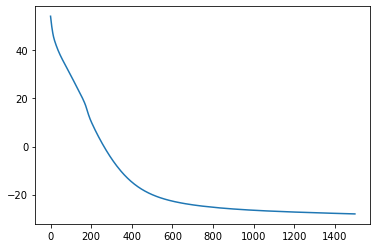

In [60]:
# instead of defining our own training loop, we will
# use the built-in support provided by the GP module
num_steps = 1500
losses = gp.util.train(vsgp, num_steps=num_steps)
plt.plot(losses);

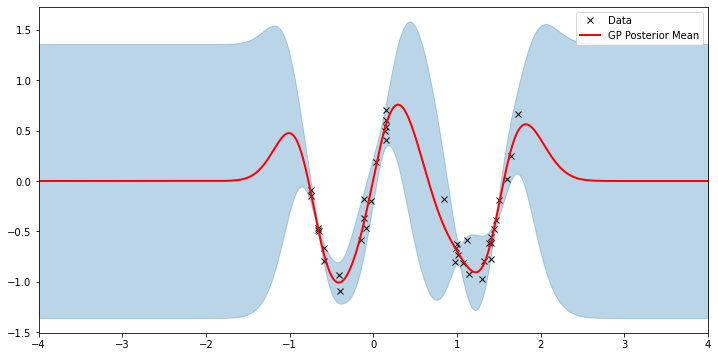

In [61]:
plot(model=vsgp, plot_observed_data=True, plot_predictions=True)

In [80]:
hmc_kernel = NUTS(vsgp)
mcmc = MCMC(hmc_kernel, num_samples=10)
mcmc.run(X_train_tensor.view(-1,), y_train_tensor.view(-1,))

Sample: 100%|██████████| 20/20 [00:00, 1904.34it/s, step size=1.00e+00, acc. prob=1.000]


In [81]:
mcmc.get_samples()

{}

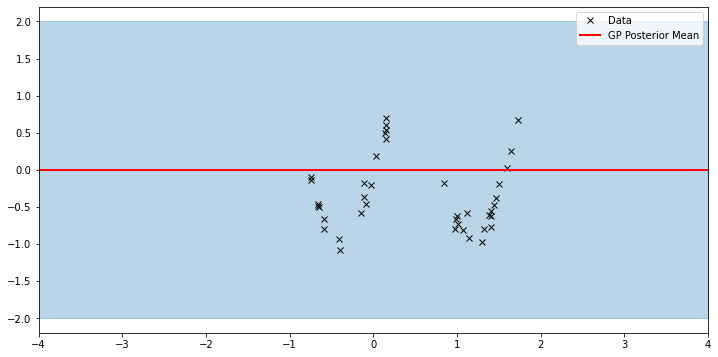

In [82]:
plot(model=vsgp, plot_observed_data=True, plot_predictions=True)

In [179]:
X_train = np.hstack([-0.75 + np.random.rand(1,20), 0.75 + np.random.rand(1,20)]).T
y_train = np.sin(4.0*X_train) + 0.1*np.random.randn(len(X_train), 1)
N_train = len(y_train)

X_train_tensor = torch.from_numpy(X_train).view(-1,)
y_train_tensor = torch.from_numpy(y_train).view(-1,)

kernel = gp.kernels.RBF(input_dim=len(X_train_tensor))
kernel.variance = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
kernel.lengthscale = pyro.nn.PyroSample(dist.Uniform(torch.tensor(0.0), torch.tensor(0.6)))
gpr = gp.models.GPRegression(X_train_tensor, y_train_tensor, kernel)

In [180]:
hmc_kernel = HMC(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=10)
mcmc.run()
ls_name = "kernel.lengthscale"
posterior_ls = mcmc.get_samples()[ls_name]

Sample: 100%|██████████| 20/20 [00:01, 18.40it/s, step size=6.04e-01, acc. prob=0.994]


In [181]:
posterior_ls

tensor([0.4982, 0.4205, 0.3964, 0.3256, 0.3092, 0.3588, 0.3298, 0.3737, 0.3853,
        0.3787], dtype=torch.float64)

In [182]:
gpr

GPRegression(
  (kernel): RBF()
)

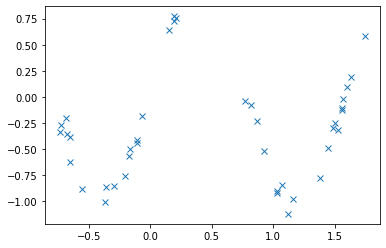

In [183]:
plt.plot(X_train_tensor, y_train_tensor, marker="x", linestyle="None")

In [184]:
X_train_tensor

tensor([-0.6794, -0.1076, -0.7235, -0.1642,  0.1902, -0.1745, -0.3618, -0.1067,
        -0.2917, -0.2044,  0.1915, -0.3639,  0.2112,  0.1554, -0.5542, -0.6806,
        -0.6492, -0.7318, -0.6556, -0.0670,  0.8212,  1.0690,  1.5949,  0.7733,
         1.5645,  1.0319,  0.8682,  1.4467,  1.3789,  1.6275,  1.4851,  1.5535,
         1.0320,  0.9274,  1.5006,  1.5568,  1.7405,  1.1626,  1.1220,  1.5264],
       dtype=torch.float64)

In [185]:
Xnew = torch.linspace(-0.2, 1, len(X_train_tensor))
f_loc, f_cov = gpr(Xnew.double(), full_cov=True)

In [186]:
f_loc, f_cov

(tensor([-0.3423, -0.3412, -0.3401, -0.3389, -0.3377, -0.3365, -0.3353, -0.3340,
         -0.3328, -0.3315, -0.3302, -0.3289, -0.3275, -0.3262, -0.3248, -0.3235,
         -0.3221, -0.3207, -0.3192, -0.3178, -0.3164, -0.3149, -0.3134, -0.3119,
         -0.3104, -0.3089, -0.3073, -0.3057, -0.3041, -0.3024, -0.3008, -0.2991,
         -0.2973, -0.2956, -0.2938, -0.2919, -0.2900, -0.2881, -0.2861, -0.2841],
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[0.0435, 0.0433, 0.0430,  ..., 0.0168, 0.0158, 0.0148],
         [0.0433, 0.0431, 0.0429,  ..., 0.0179, 0.0169, 0.0159],
         [0.0430, 0.0429, 0.0428,  ..., 0.0190, 0.0180, 0.0170],
         ...,
         [0.0168, 0.0179, 0.0190,  ..., 0.0418, 0.0417, 0.0416],
         [0.0158, 0.0169, 0.0180,  ..., 0.0417, 0.0417, 0.0417],
         [0.0148, 0.0159, 0.0170,  ..., 0.0416, 0.0417, 0.0417]],
        dtype=torch.float64, grad_fn=<ExpandBackward0>))

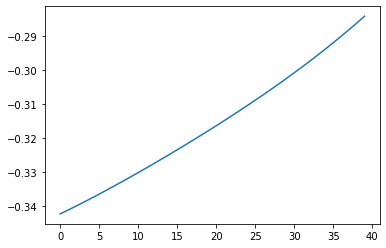

In [187]:
plt.plot(f_loc.detach())

In [82]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(Xtest,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
    limits=[0, 5],
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(limits[0], limits[1])

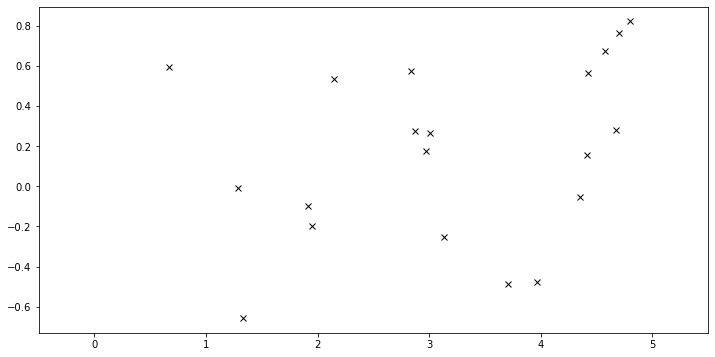

In [4]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [12]:
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

In [88]:
N = 20
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,)).double()
y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,)).double()

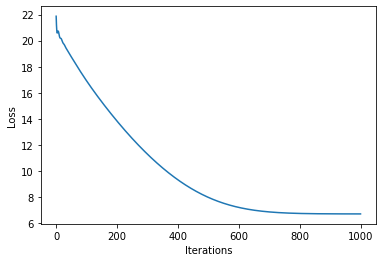

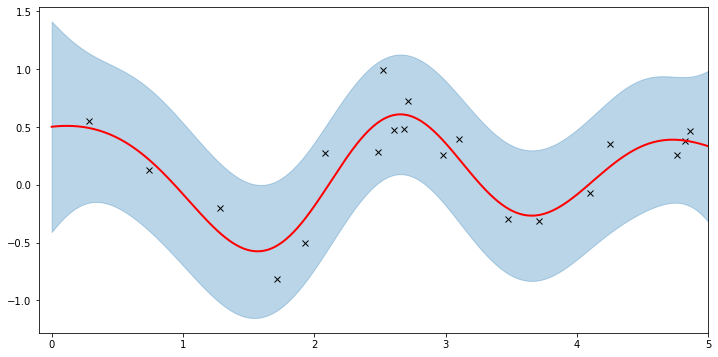

In [108]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(1)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.01))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 1000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)
X_test = torch.linspace(0, 5, 500).double()  # test inputs
plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[-0.1, 5])

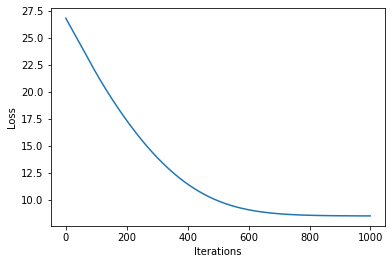

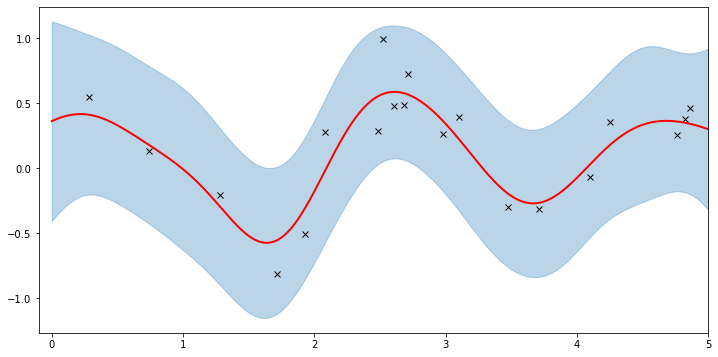

In [93]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.0))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 1000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)
X_test = torch.linspace(0, 5, 500).double()  # test inputs
plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[-0.1, 5])

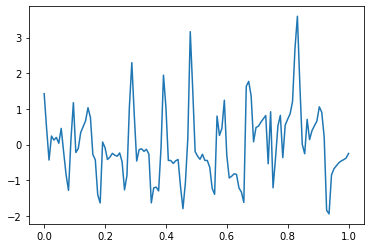

In [113]:
y = -torch.tensor(height).double()
X = torch.linspace(0, 1, len(y)).double()
y = (y - y.mean())/y.std()
plt.plot(X, y)

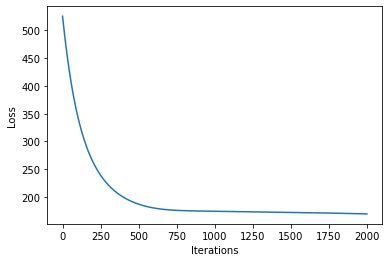

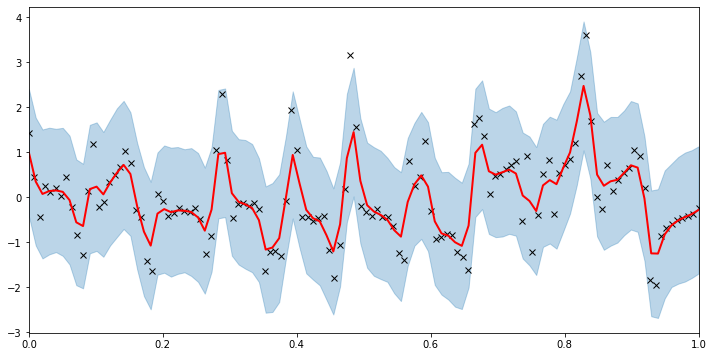

In [150]:
y = -torch.tensor(height).double()
X = torch.linspace(0, 1, len(y)).double()
y = (y - y.mean())/y.std()

# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Exponential(
    input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.9))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.2))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)
X_test = torch.linspace(0, 1, 100).double()  # test inputs
plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])

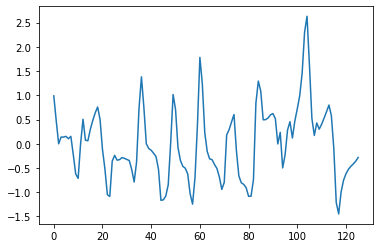

In [159]:
plt.plot(gpr(X_test, full_cov=True)[0].detach())

corr = 0.9563785614613594, 
mae = 0.2529011472528777, 
rae = 0.32776259155272525, 
rmse = 0.35894244855349106
corr = 0.3141702159993954, 
mae = 0.9115492222713323, 
rae = 1.1813775408491087, 
rmse = 1.1688547563568734


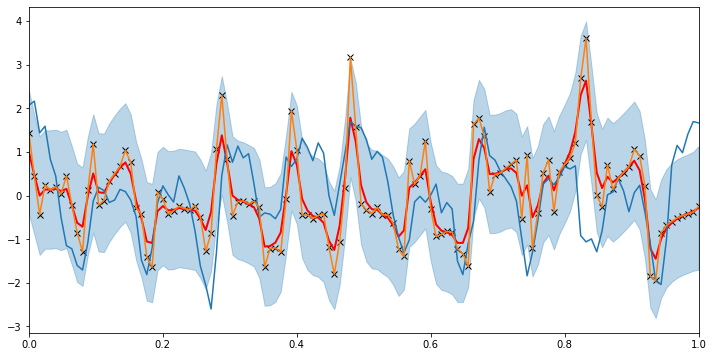

In [169]:
upl = detrend(uplift)
X_test = torch.linspace(0, 1, len(uplift)).double()  # test inputs
plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])
plt.plot(X_test, (upl - np.mean(upl)) / np.std(upl))
plt.plot(X_test, y)

preds = gpr(X_test, full_cov=True)[0].detach()
corr, mae, rae, rmse = compute_error(y.numpy(), preds.numpy())
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")
corr, mae, rae, rmse = compute_error(y.numpy(), (upl - np.mean(upl)) / np.std(upl))
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

In [170]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Exponential(
    input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.1)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.1))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.9))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.2))

In [172]:
hmc_kernel = HMC(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=1000, warmup_steps=100)
mcmc.run()

Sample: 100%|██████████| 1100/1100 [04:32,  4.04it/s, step size=9.48e-02, acc. prob=0.991]


In [33]:
mcmc.get_samples()

{'kernel.lengthscale': tensor([ 2.4468,  3.9878,  0.8719,  0.8719,  0.4786,  0.3708,  0.3708,  0.6424,
          1.3808,  1.3117,  1.1587,  1.8193,  1.1930,  3.2156,  3.7844, 10.3047,
          9.0541,  2.2194,  4.8516,  2.1914,  1.4235,  1.5911,  3.9073, 10.6658,
         18.3845, 18.3845,  2.7619,  4.0324,  4.4898,  5.4014,  5.4014,  3.9015,
          3.1530,  2.6734,  6.5465,  5.0283,  5.3052,  7.2774,  6.0649,  8.9805,
          7.1832,  2.3711,  0.9724,  0.3545,  0.6556,  0.5122,  1.2390,  0.5763,
          0.2919,  1.7472,  1.1645,  0.6859,  4.1841,  3.5855,  6.2474,  1.7471,
          2.3810,  2.3810,  1.2181,  1.0346,  1.8860,  0.8071,  1.7944,  6.6728,
          7.1138,  3.6583,  3.7397,  2.4451,  4.3416,  5.9312,  1.0932,  1.0932,
          3.5655,  3.8246,  0.8834,  1.3294,  1.5933,  1.9218,  1.0927,  3.1922,
          0.8460,  0.7523,  0.4586,  1.2053,  0.8076,  1.1891,  3.8156,  2.6139,
          6.7680,  7.2347,  8.6052,  4.8413,  1.9843,  1.2130,  4.3553,  0.7364,
      

corr = 0.9428796990911212, 
mae = 0.28355146610126153, 
rae = 0.3674857325775404, 
rmse = 0.4009824403729168
corr = 0.3141702159993954, 
mae = 0.9115492222713323, 
rae = 1.1813775408491087, 
rmse = 1.1688547563568734


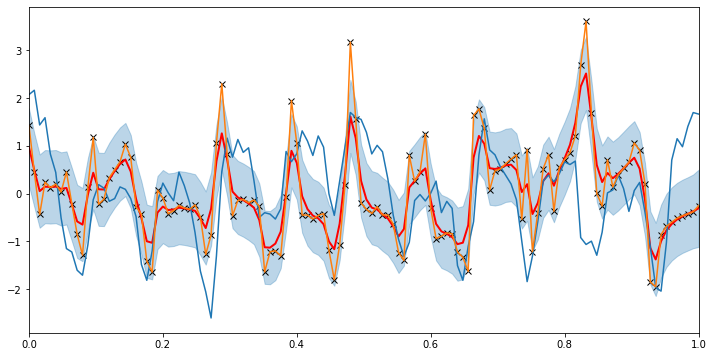

In [173]:
upl = detrend(uplift)
X_test = torch.linspace(0, 1, len(uplift)).double()  # test inputs
plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])
plt.plot(X_test, (upl - np.mean(upl)) / np.std(upl))
plt.plot(X_test, y)

preds = gpr(X_test, full_cov=True)[0].detach()
corr, mae, rae, rmse = compute_error(y.numpy(), preds.numpy())
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")
corr, mae, rae, rmse = compute_error(y.numpy(), (upl - np.mean(upl)) / np.std(upl))
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

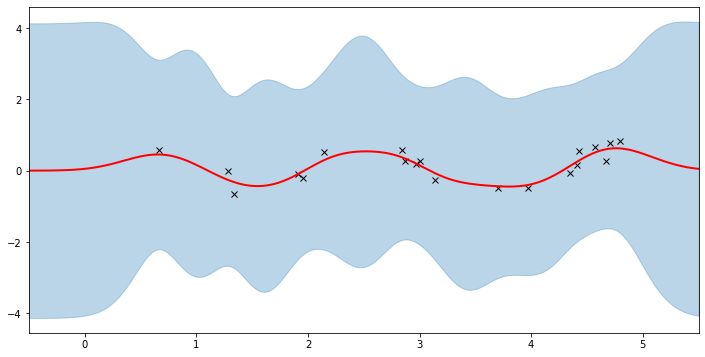

In [34]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [71]:
y = torch.tensor(height).double()
X = torch.linspace(0, 1, len(y)).double()
y = (y - y.mean())/y.std()

# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1.0))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, .05))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

In [72]:
hmc_kernel = HMC(gpr.model)
mcmc = MCMC(hmc_kernel, num_samples=400, warmup_steps=50)
mcmc.run()

Sample: 100%|██████████| 450/450 [01:06,  6.74it/s, step size=2.98e-01, acc. prob=0.967]


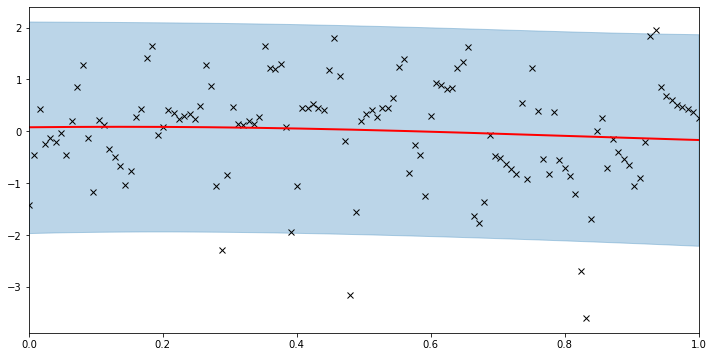

In [73]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [ ]:
X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
# y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

In [40]:
X

tensor([4.4113, 4.5750, 1.9143, 4.7965, 1.9522, 3.0045, 1.2829, 3.9682, 4.7039,
        0.6659, 4.6730, 2.9679, 4.3470, 2.8386, 3.7055, 2.1470, 4.4272, 2.8695,
        1.3329, 3.1372])

In [39]:
y.shape

torch.Size([20])